In [1]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !pip install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# - Update a specific package
# !pip install pmdarima -U
# - Update a package to specific version
# !pip install --upgrade pmdarima==2.0.2
# Note: If your environment doesn't support "!pip install", use "!mamba install"

In [3]:
!pip install tqdm pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 666.1/666.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 10.3 MB/s eta 0:00:00a 0:00:01


In [7]:
from tqdm import tqdm
#import skillsnetwork
import numpy as np
import pandas as pd
#from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms 
%matplotlib inline
from math import ceil

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

In [9]:
df = pd.read_csv('ab_data.csv')

In [11]:
df.sample(5)

,user_id,timestamp,group,landing_page,converted
254341,909638,2017-01-07 10:04:06.383628,control,old_page,0
254137,669949,2017-01-05 14:16:39.836227,treatment,new_page,0
91817,796136,2017-01-22 10:58:00.996429,control,old_page,0
130019,800165,2017-01-21 22:20:49.110400,control,old_page,1
45376,780452,2017-01-05 16:35:21.389566,treatment,new_page,0


In [13]:
df['version'] = np.where(df['landing_page'] == 'new_page', 'dark_mode', 'light_mode')
df.head(5)

,user_id,timestamp,group,landing_page,converted,version
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,light_mode
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,light_mode
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,dark_mode
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,dark_mode
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,light_mode


In [15]:
df['group'].value_counts()

group
treatment    147276
control      147202
Name: count, dtype: int64

In [17]:
df['landing_page'].value_counts()

landing_page
old_page    147239
new_page    147239
Name: count, dtype: int64

In [19]:
# filter the data based off of the version (dark or light mode)
old_conversion = df[df['version'] == 'light_mode']
new_conversion = df[df['version'] == 'dark_mode']

# get the conversion rates
light_converted = old_conversion['converted'].mean()
dark_converted = new_conversion['converted'].mean()

# print the results
print("The conversion rate in the group using light mode is: %.2f%%" % (100 * light_converted))
print("The conversion rate in the group using dark mode is: %.2f%%" % (100 * dark_converted))

The conversion rate in the group using light mode is: 12.05%
The conversion rate in the group using dark mode is: 11.88%


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
 5   version       294478 non-null  object
dtypes: int64(2), object(4)
memory usage: 13.5+ MB


In [25]:
# Our dataset has 294,478 entries and 294,478 non-null. This means that we don't have any null values, 
# hence we don't need to drop any observations... for now.

In [29]:
### Designing the experiment
# Hypothesis Testing


In [31]:
### Collect & Prepare Data
# check if some users appear multiple times
user_sessions = df['user_id'].value_counts()

multiple_times_user = user_sessions[user_sessions > 1].count()

multiple_times_user

3894

In [33]:
dr = user_sessions[user_sessions > 1].index
df = df[~df['user_id'].isin(dr)]

df.head(5)

,user_id,timestamp,group,landing_page,converted,version
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,light_mode
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,light_mode
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,dark_mode
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,dark_mode
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,light_mode


In [35]:
df.shape[0]

286690

In [37]:
''' Picking the sample

Our data contains 286,690 rows, which is not little. 
There are instances where datasets extend into the millions, presenting a considerable challenge in terms of both time and space for conducting testing. 
We can derive conclusive insights by working with a sample of our data. 
However, determining the optimal sample size from the outset may not be immediately evident.

However, we do know:

    𝛼=5%

The power is the test is usually set to 1−𝛽=80%
effect size: 2%

Usually, a good baseline conversion rate falls within the range of 10−15%
, let's use 13% as our baseline conversion rate in this case. Moreover, our team anticipates a conversion rate of 15%, thereby justifying the chosen effect size of 2%

.

Fortunately, Python facilitates this process seamlessly through the statsmodel library!
'''

" Picking the sample\n\nOur data contains 286,690 rows, which is not little. There are instances where datasets extend into the millions, presenting a considerable challenge in terms of both time and space for conducting testing. We can derive conclusive insights by working with a sample of our data. However, determining the optimal sample size from the outset may not be immediately evident.\n\nHowever, we do know:\n\n    𝛼=5%\n\nThe power is the test is usually set to 1−𝛽=80%\neffect size: 2%\n\nUsually, a good baseline conversion rate falls within the range of 10−15%\n, let's use 13% as our baseline conversion rate in this case. Moreover, our team anticipates a conversion rate of 15%, thereby justifying the chosen effect size of 2%\n\n.\n\nFortunately, Python facilitates this process seamlessly through the statsmodel library!\n"

In [39]:
effect_size = sms.proportion_effectsize(0.13, 0.15)

sample_size = sms.NormalIndPower().solve_power(
    effect_size,
    power = 0.8,
    alpha = 0.05,
    ratio = 1
)

sample_size = ceil(sample_size)

sample_size

4720

In [41]:
#We would need to sample 4,720 observations from each group so that our test can be effective.

In [43]:
# The treatment and control samples
trt_sample = df[df['group']=='treatment'].sample(n=sample_size, random_state=888)

con_sample = df[df['group'] == 'control'].sample(n=sample_size, random_state=0)

# Combining into one dataframe and resetting the indices
df = pd.concat([con_sample, trt_sample], axis=0)
df.reset_index(drop=True, inplace=True)

df.sample(5)

,user_id,timestamp,group,landing_page,converted,version
2163,675478,2017-01-18 08:27:38.005543,control,old_page,0,light_mode
3218,799122,2017-01-19 18:43:15.013870,control,old_page,0,light_mode
4160,864933,2017-01-08 12:31:53.428730,control,old_page,0,light_mode
2782,933740,2017-01-07 07:07:12.257873,control,old_page,0,light_mode
1429,845674,2017-01-12 13:34:52.196447,control,old_page,0,light_mode


In [45]:
### Visualize the results¶

In [47]:
df.groupby(['group','version']).agg({'converted': 'mean'})

,,converted
group,version,
control,light_mode,0.111017
treatment,dark_mode,0.125000


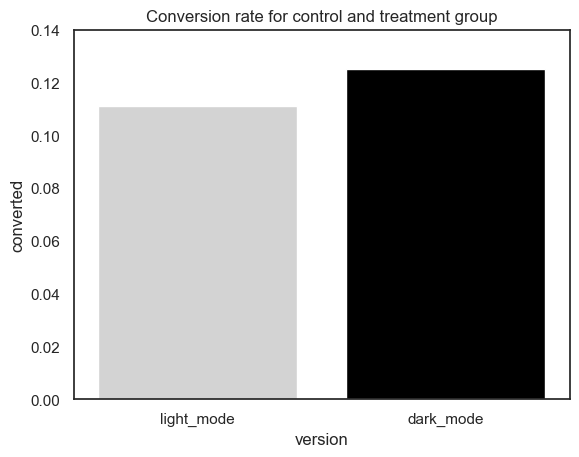

In [67]:
sns.barplot(x = df['version'], y = df['converted'], palette = ['lightgray', 'black'], ci = False)
plt.ylim(0, 0.14)
plt.title('Conversion rate for control and treatment group')
plt.show()

In [70]:
### Testing the hypothesis

# What is a p-value?

# A p-value is the probability to observe a value as extreme as the observed value assuming that the null hypothesis is true.

# In step 1, we set that we have a 95% level of confidence, which results in a level of significance of 5%.


In [72]:
conv_cont = df[df['group'] =='control']['converted']

conv_trt = df[df['group'] =='treatment']['converted']

n_cont = conv_cont.count()

n_trt = conv_trt.count()

num_converted = [conv_cont.sum(), conv_trt.sum()]

nobs = [n_cont, n_trt]

# p-value?
z_stat, pval = sms.proportions_ztest(num_converted, nobs=nobs)

pval

0.03524195278525257

In [84]:

#How to interpret a p-value?
#| Values of p | Inference |
#| ---     |    --- |
#|         p > 0.1  | No evidence against the null hypohesis|
#|  0.05 < p < 0.10 | Weak evidence against the null hypohesis|
#|  0.01 < p < 0.05 | Moderate evidence against the null hypohesis|
#|  0.05 < p < 0.001| Good evidence against the null hypohesis|
#| 0.001 < p < 0.01 | Strong evidence against the null hypohesis|
#|         p < 0.001| Very strong evidence against the null hypohesis|


# From the result, the p-value is 0.0352, which is less than 0.05. This means that we have moderate evidence against the null hypothesis.

# In this case, we would reject the null hypothesis. This means that we cannot say that there is no difference in conversion rate 
 # between dark mode and light mode users.

# The team can definitely choose to implement a dark mode version of the blog, but can continue monitoring the conversion results as time goes by.
